In [78]:
import pickle
import time
start_time = time.time()
import numpy as np
import os
import SimpleITK as sitk
import json
import ProstateLesionDetectionUtils
import random
import plotly.express as px
import matplotlib.pyplot as plt
from scipy import ndimage
import math
import tensorflow_addons as tfa
import tensorflow as tf
with open(r"E:\DIMITRIS_DEEP_LEARNING\DATASETS\UC1_Nifti_Datasets_Paths\Datasets.json", 'r') as f:
    datasets = json.load(f)
p158 = r"E:\DIMITRIS_DEEP_LEARNING\DATASETS\PROSTATE158\DATASETPICKLE\Nifti_files"
picai = r"E:\DIMITRIS_DEEP_LEARNING\DATASETS\PICAI_DATA\Nifti_files"
prostatenet = r"E:\DIMITRIS_DEEP_LEARNING\DATASETS\PROSTATENET_UC1_LESIONS\nnUNet_raw\Dataset011_ProstateNet"
with open(r"E:\DIMITRIS_DEEP_LEARNING\DATASETS\PROSTATENET_UC1_LESIONS\nnUNet_raw\Dataset011_ProstateNet\folds.json", 'r') as f:
    ValidationFolds = json.load(f)

def PrepareTraining(pat):
    dataset, labels = {}, {}
    for key in pat.keys():
        dataset.update({key:tf.expand_dims(tf.convert_to_tensor(np.transpose(np.stack([pat[key]["T2"], pat[key]["ADC"], pat[key]["DWI"]]),(1,2,3,0))), axis = 0)})
        labels.update({key:tf.convert_to_tensor(np.expand_dims(pat[key]["Lesions"], axis = -1))})
    return dataset, labels

In [9]:
loader = ProstateLesionDetectionUtils.DatasetsLoaders.Nifti_Loader.LoadSitkImages(ptdc = datasets["ProstateNet"], folder = prostatenet)
patients = loader.load_npobj()

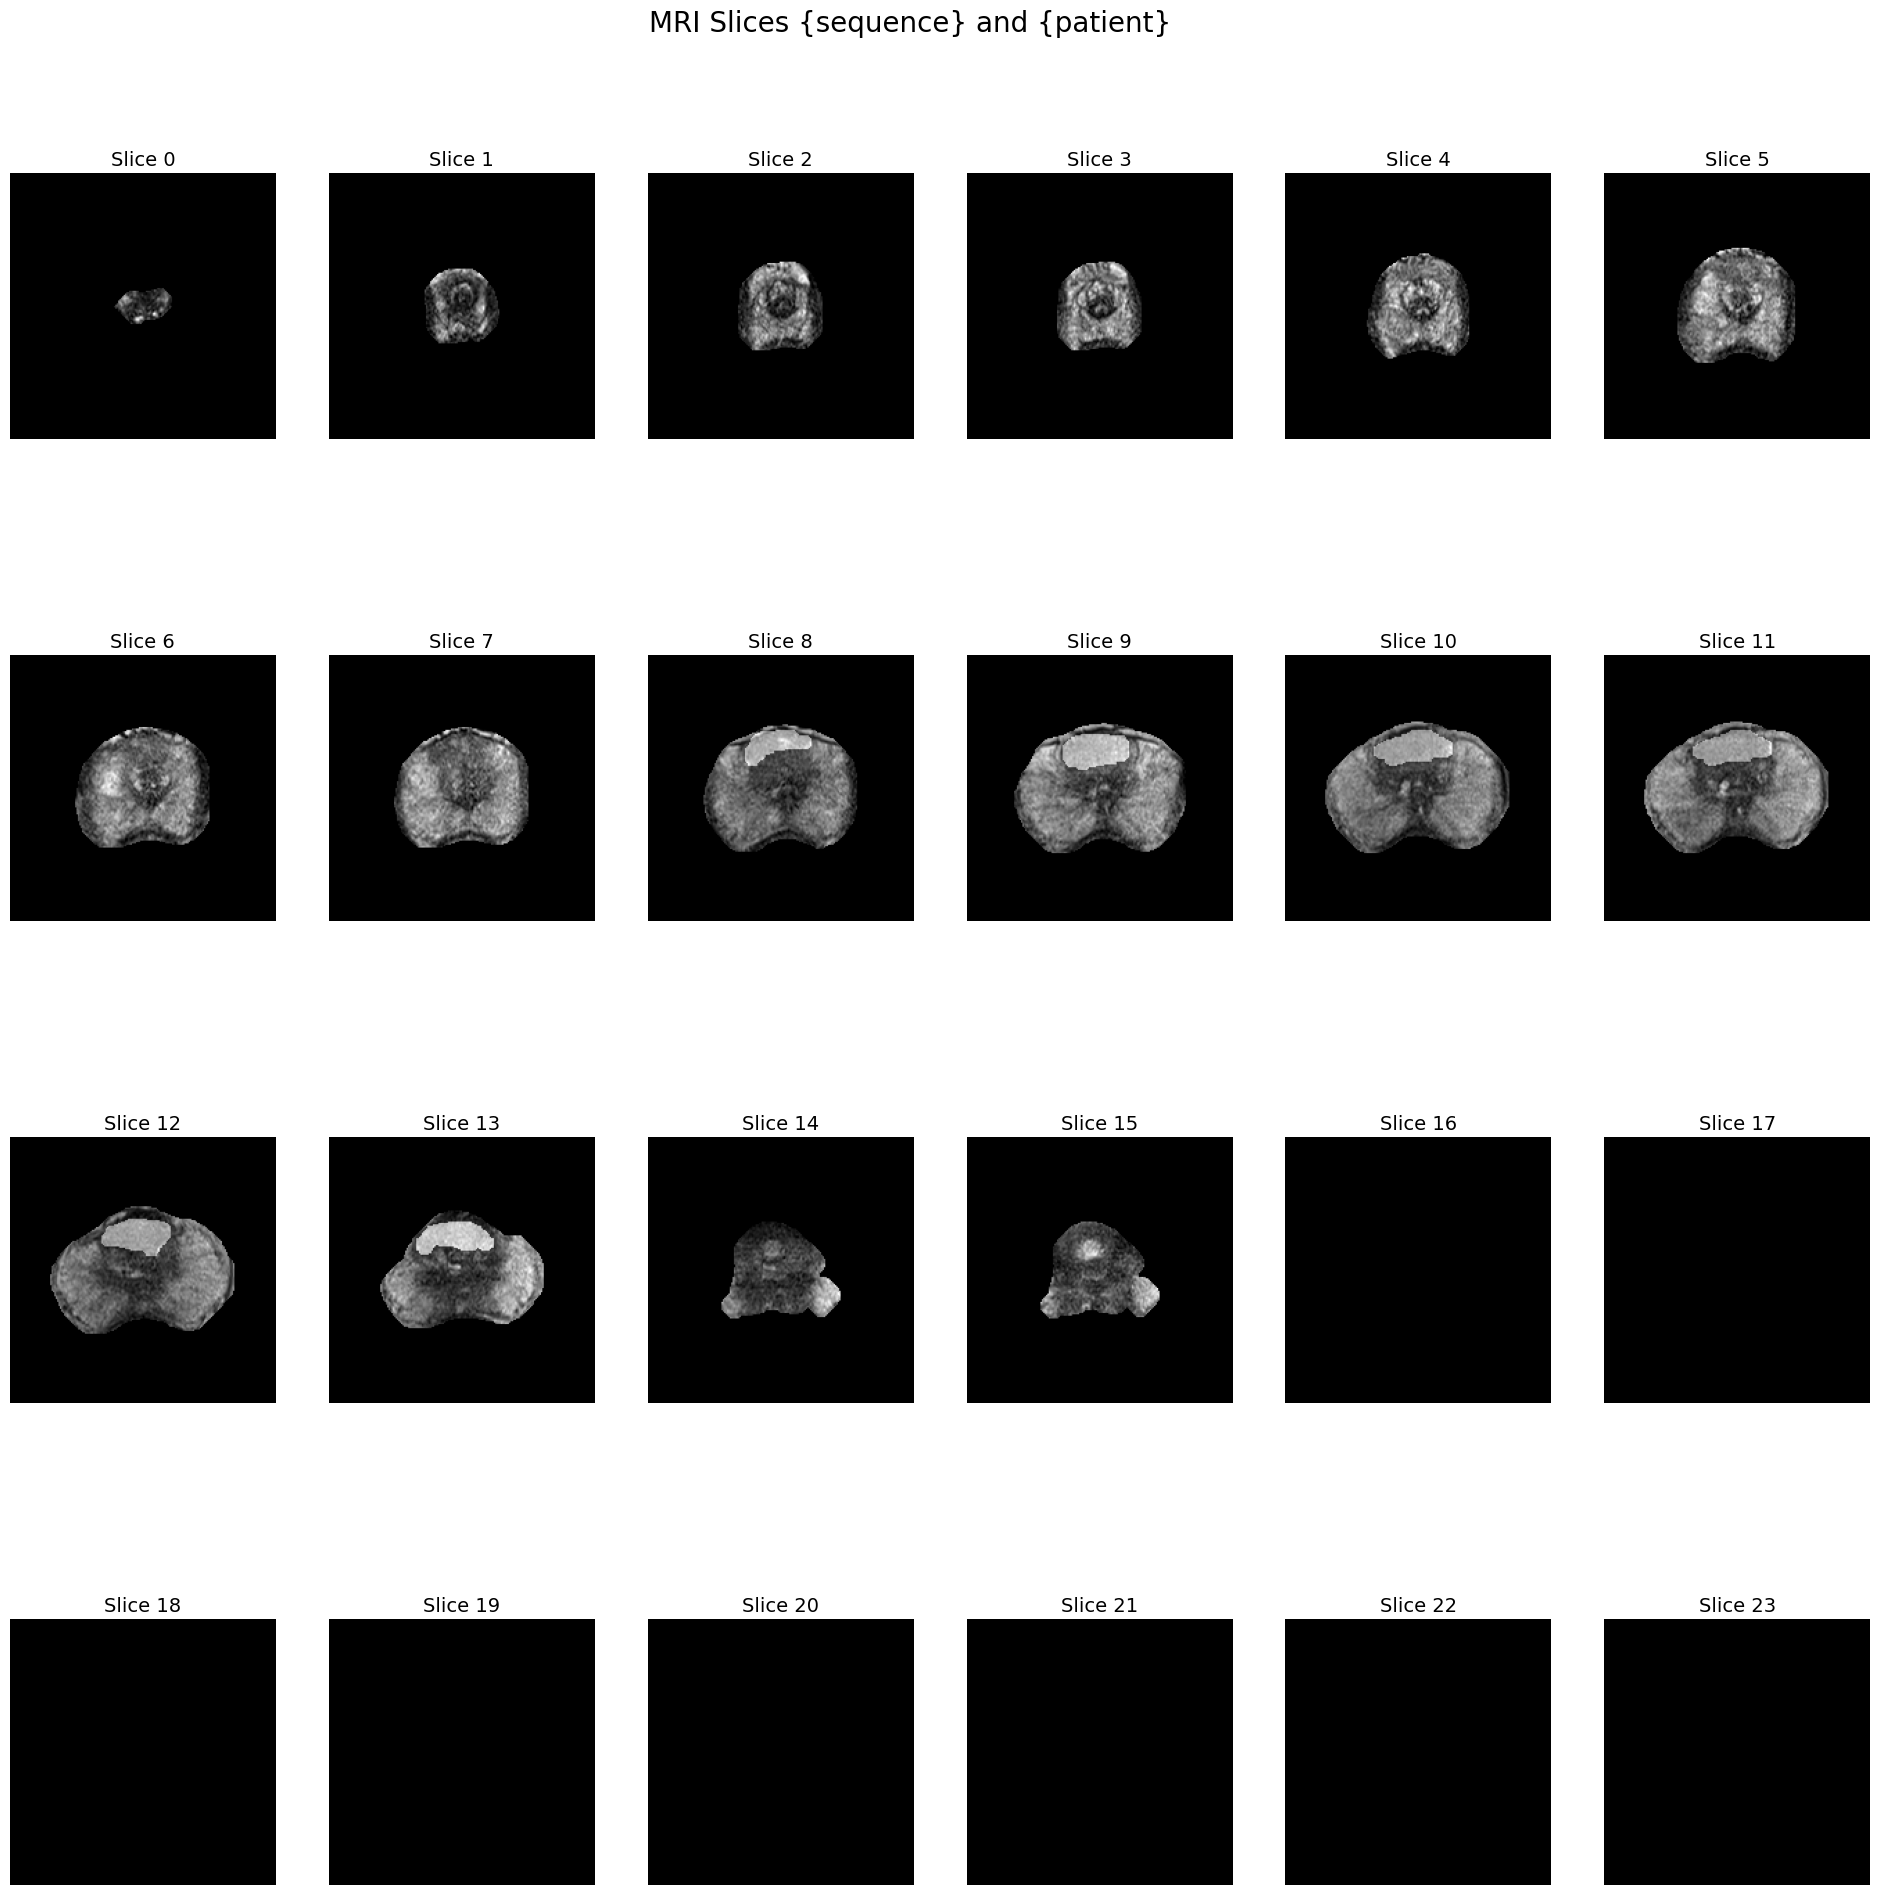

In [13]:
vis = ProstateLesionDetectionUtils.DatasetsProcessing.Visualization.Visualizer(patients)
vis.np_vis("T2", "PCa-303901718985542921512314477627180280896")

In [31]:
dt = ProstateLesionDetectionUtils.DetectionMetrics.ModelDetoriention.DetorientLesions(patients, rates = [15,40,50])
dt.CreateZones()
dt.CreateZaxisZone()
dt.KeepZonesNonZeroImageValues()
zones = dt.GetZones()
zaxis = dt.GetZaxisZones()

In [85]:
dataset, labels = PrepareTraining(patients)

x_train = {key:dataset[key] for key in dataset.keys() if key not in ValidationFolds["Fold 0"]}
y_train = {key:labels[key] for key in labels.keys() if key not in ValidationFolds["Fold 0"]}

x_test = {key:dataset[key] for key in dataset.keys() if key in ValidationFolds["Fold 0"]}
y_test = {key:labels[key] for key in labels.keys() if key in ValidationFolds["Fold 0"]}

In [83]:
len(x_train),len(y_train),len(x_test),len(y_test)

(289, 289, 73, 73)

In [86]:
Xtrain = list(x_train.values())
Ytrain = list(y_train.values())
Xtest = list(x_test.values())
Ytest = list(y_test.values())

In [91]:
start_time = time.time()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
FILTERS = [32,64,128,256, 512, 1024]
Pool_size = ((2,2,2),(2,2,2),(2,2,2), (1,2,2), (1,2,2))
VOLSIZE = 24
INPSIZE = 192
BATCH_SIZE=4
EPOCHS = 1000
INIT_LR = 1e-4
MAX_LR = 1e-2
TQDM_CB=tfa.callbacks.TQDMProgressBar()

METRICS = "acc" # tfa.metrics.F1Score(num_classes=2, threshold=0.5)

STEPS_PER_EPOCH = len(Xtrain) // BATCH_SIZE # len(train_data)

CLR = lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH,  # Usually set to total number of training steps/epochs
    decay_rate=0.96,
    staircase=True
)
# CLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
#     maximal_learning_rate=MAX_LR,
#     scale_fn=lambda x: 1/(2.**(x-1)),
#     step_size=2 * STEPS_PER_EPOCH)
LOSS = tfa.losses.sigmoid_focal_crossentropy  #tfa.losses.sigmoid_focal_crossentropy
OPTIMIZER = tf.keras.optimizers.Adam(CLR)

name_folder = str(input())
try:
    os.mkdir(os.path.join(r"E:\DIMITRIS_DEEP_LEARNING\RESULTS\PROCANCER_UC1_RESULTS",name_folder))
except:
    pass

SAVE = os.path.join(r"E:\DIMITRIS_DEEP_LEARNING\RESULTS\PROCANCER_UC1_RESULTS","name_folder\CheckPoint_Weights.tf")

CHECK_CB = tf.keras.callbacks.ModelCheckpoint(SAVE,save_weights_only=False,save_best_only=True)
#EARLY_STOP = tf.keras.callbacks.EarlyStopping(patience = 8)
CALLBACKS=[CHECK_CB,TQDM_CB]#
train_dataset = tf.data.Dataset.from_tensor_slices((Xtrain, Ytrain))
val_dataset = tf.data.Dataset.from_tensor_slices((Xtest, Ytest))


train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

TrainParams = {"LOSS":LOSS, "OPTIMIZER":OPTIMIZER, "CALLBACKS":CALLBACKS,"POOL_SIZE":Pool_size,
               "BATCH_SIZE":BATCH_SIZE, "FILTERS":FILTERS, "INPUT_SIZE":INPSIZE, "METRICS":METRICS,
               "WEIGHTS":SAVE,
               "VOLUME_SIZE":24, "EPOCHS":EPOCHS, "TRAIN_DATASET":train_dataset,"VAL_DATASET":val_dataset,"DENSE_SIZE":8, "PATCH_SIZE_XY": 4,
                "PATCH_SIZE_Z": 1,
                "TRANSF_HEADS": 12,
                "TRANSF_LAYERS": 8,
                "DROP_RATE": 0.5}

print((time.time() - start_time))

ResourceExhaustedError: OOM when allocating tensor with shape[289,1,24,192,192,3] and type double on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Pack] name: component_0

In [ ]:
start_time = time.time()
mod = ProstateLesionDetectionUtils.DetectionModels.Models3D.TransUnet3D.transunet3d.TrainTransUnet(TrainParams)
mod.ModelBuild()
mod.ModelCompile()
#mod.LoadTrained()
mod.ModelFit()
unet = mod.GetModel()
print((time.time() - start_time))